## CartPole-v0, solved with Q-learning

In [58]:
import numpy as np
import torch
import random
from matplotlib import pylab as plt
import gym
from collections import deque

In [11]:
# Setup environment
env = gym.make("CartPole-v0")
state = env.reset()
for i in range(100):
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    print("State: ", env.state)
    print("Action taken: ", action)
    print("Reward: ", reward)
    
    if done:
        state = env.reset()
        
env.close()
env.reset()

State:  (0.005661503317397601, -0.20128399558472582, -0.017767405728015048, 0.24597305418164195)
Action taken:  0
Reward:  1.0
State:  (0.0016358234057030846, -0.39614773792641855, -0.012847944644382207, 0.5329991904091529)
Action taken:  0
Reward:  1.0
State:  (-0.006287131352825287, -0.20084746824217325, -0.002187960836199149, 0.2362957723583825)
Action taken:  1
Reward:  1.0
State:  (-0.010304080717668751, -0.005694326107379105, 0.002537954610968501, -0.05707650014286364)
Action taken:  1
Reward:  1.0
State:  (-0.010417967239816334, 0.18939114340632038, 0.001396424608111228, -0.348957604118936)
Action taken:  1
Reward:  1.0
State:  (-0.006630144371689926, 0.3844932059388093, -0.005582727474267492, -0.6411998638793464)
Action taken:  1
Reward:  1.0
State:  (0.0010597197470862598, 0.579692535555412, -0.01840672475185442, -0.9356356088571529)
Action taken:  1
Reward:  1.0
State:  (0.0126535704581945, 0.38482361488935357, -0.03711943692899748, -0.6487930152529664)
Action taken:  0
Rewar

State:  (0.004070274897501858, -0.6273978558370952, 0.03639090499399325, 0.9448695176157433)
Action taken:  0
Reward:  1.0
State:  (-0.008477682219240047, -0.43278450288404313, 0.05528829534630812, 0.6638393262030389)
Action taken:  1
Reward:  1.0
State:  (-0.01713337227692091, -0.6286302362750944, 0.0685650818703689, 0.9734055242209843)
Action taken:  0
Reward:  1.0
State:  (-0.0297059770024228, -0.43449187394769717, 0.08803319235478858, 0.7030245640669202)
Action taken:  1
Reward:  1.0
State:  (-0.038395814481376744, -0.6307164590567598, 0.10209368363612699, 1.0220699874064372)
Action taken:  0
Reward:  1.0
State:  (-0.05101014366251194, -0.8270393526096967, 0.12253508338425573, 1.3449843650334932)
Action taken:  0
Reward:  1.0
State:  (-0.06755093071470587, -0.6336528814545983, 0.14943477068492558, 1.0930149156819826)
Action taken:  1
Reward:  1.0
State:  (-0.08022398834379783, -0.4407815603830734, 0.17129506899856523, 0.8507026409941933)
Action taken:  1
Reward:  1.0
State:  (-0.08

In [5]:
# Setup model
l1 = 4
l2 = 150
l3 = 100
l4 = 2
gamma = 0.9
epsMin, epsMax = 0.2, 0.7
epsilon = epsMax
learning_rate = 1e-3

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
# Train phase
epochs = 1000
losses = []

for i in range(epochs):
    state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
    state1 = torch.from_numpy(state_).float()
    done = False
    lossesEp = []
    while not done:
        qval = model(state1)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        if (random.random() < epsilon):
#             print('Sample random')
            action = np.random.randint(0, 2)
        else:
#             print('Sample Q')
            action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print('Action: ', action)
#         print('State: ', state)
        
        state2_ = np.asarray(state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state2 = torch.from_numpy(state2_).float()
        
        with torch.no_grad():
            newQ = model(state2)
            
        maxQ = torch.max(newQ)
        
        Y = reward + (gamma * maxQ) if not done else reward
        
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action] 
        
        loss = loss_fn(X, Y)
#         print('Episode: ', i, '\t', 'Loss: ', loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        lossesEp.append(loss.item())
        optimizer.step()
        state1 = state2
    
    # Accumulate loss
    lossEpMean = sum(lossesEp) / len(lossesEp)
    losses.append(lossEpMean)
    print('Episode', i + 1, '\t', 'Loss:', lossEpMean)
    
    # Reset environment
    env.reset()
    
    if epsilon > epsMin:
        epsilon -= ((epsMax - epsMin) / epochs)

c:\users\dan\appdata\local\programs\python\python36\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 1 	 Loss: 50.519622802734375
Episode 2 	 Loss: 2.0412250977009534
Episode 3 	 Loss: 0.2861251859755475
Episode 4 	 Loss: 8.466372757218778
Episode 5 	 Loss: 2.426937755594346
Episode 6 	 Loss: 2.6945067682303487
Episode 7 	 Loss: 0.31857470419097605
Episode 8 	 Loss: 0.2820355370089118
Episode 9 	 Loss: 0.41657744263502994
Episode 10 	 Loss: 2.0638530782320728
Episode 11 	 Loss: 0.2036758333649277
Episode 12 	 Loss: 0.2758534633136712
Episode 13 	 Loss: 0.32372890592732184
Episode 14 	 Loss: 0.2648566713935959
Episode 15 	 Loss: 0.2655161720618192
Episode 16 	 Loss: 0.24023414363066947
Episode 17 	 Loss: 2.8794925328032583
Episode 18 	 Loss: 0.2771084042479465
Episode 19 	 Loss: 0.4208181007534313
Episode 20 	 Loss: 0.39076605475482795
Episode 21 	 Loss: 0.34647901798556174
Episode 22 	 Loss: 0.4488995906908349
Episode 23 	 Loss: 3.0526540829035054
Episode 24 	 Loss: 2.6139729562112026
Episode 25 	 Loss: 1.8668849206587765
Episode 26 	 Loss: 0.3598046952372365
Episode 27 	 Loss

Episode 213 	 Loss: 0.11792788115652116
Episode 214 	 Loss: 0.058614602256856885
Episode 215 	 Loss: 0.43114453011959086
Episode 216 	 Loss: 0.4029570222415927
Episode 217 	 Loss: 0.08954716769971861
Episode 218 	 Loss: 0.7964012741093838
Episode 219 	 Loss: 0.3100486838465024
Episode 220 	 Loss: 0.19825420491985338
Episode 221 	 Loss: 0.16128759359820047
Episode 222 	 Loss: 3.334774772231079
Episode 223 	 Loss: 2.3105385961602085
Episode 224 	 Loss: 2.028636447386816
Episode 225 	 Loss: 0.4717060852180703
Episode 226 	 Loss: 0.13533860709945572
Episode 227 	 Loss: 0.11926434510930449
Episode 228 	 Loss: 0.1595453469401184
Episode 229 	 Loss: 0.4156598346324699
Episode 230 	 Loss: 0.19607930595080347
Episode 231 	 Loss: 0.11959707509532892
Episode 232 	 Loss: 0.2193996582545525
Episode 233 	 Loss: 0.1282885846357424
Episode 234 	 Loss: 0.3211761256701088
Episode 235 	 Loss: 0.2341487989957469
Episode 236 	 Loss: 0.12965818626929557
Episode 237 	 Loss: 0.133406618776197
Episode 238 	 Lo

Episode 423 	 Loss: 0.11149824165049274
Episode 424 	 Loss: 0.15661771144093584
Episode 425 	 Loss: 1.0817918635679475
Episode 426 	 Loss: 3.1131350426719737
Episode 427 	 Loss: 2.245831324951723
Episode 428 	 Loss: 0.41381268080182054
Episode 429 	 Loss: 0.1448312314758215
Episode 430 	 Loss: 0.41125511426150296
Episode 431 	 Loss: 1.4249969848897308
Episode 432 	 Loss: 0.43831506927215286
Episode 433 	 Loss: 0.19175759845519189
Episode 434 	 Loss: 1.04335512976158
Episode 435 	 Loss: 0.12489105816456644
Episode 436 	 Loss: 0.10897847834746244
Episode 437 	 Loss: 0.08837076758307966
Episode 438 	 Loss: 0.6498760024687863
Episode 439 	 Loss: 3.163364001679628
Episode 440 	 Loss: 2.2679910457712444
Episode 441 	 Loss: 0.22913031026877284
Episode 442 	 Loss: 0.0931506381567963
Episode 443 	 Loss: 2.446049763184874
Episode 444 	 Loss: 0.1322938945361159
Episode 445 	 Loss: 0.23599804178980618
Episode 446 	 Loss: 2.424348542323479
Episode 447 	 Loss: 0.16462436529093646
Episode 448 	 Loss:

Episode 632 	 Loss: 0.11293779771839775
Episode 633 	 Loss: 0.08582542574576403
Episode 634 	 Loss: 1.0089745617885073
Episode 635 	 Loss: 1.6974375417380037
Episode 636 	 Loss: 1.3059067132572333
Episode 637 	 Loss: 0.8387471844944817
Episode 638 	 Loss: 0.26798611050463933
Episode 639 	 Loss: 0.15113849890251457
Episode 640 	 Loss: 0.1714772406993988
Episode 641 	 Loss: 0.15544866594449386
Episode 642 	 Loss: 0.23618635986816586
Episode 643 	 Loss: 0.15734551469071034
Episode 644 	 Loss: 0.04809076525578407
Episode 645 	 Loss: 0.41500280691017905
Episode 646 	 Loss: 0.6405286154116812
Episode 647 	 Loss: 0.15510548133093097
Episode 648 	 Loss: 0.06881148271526091
Episode 649 	 Loss: 0.20345905724464547
Episode 650 	 Loss: 0.10212267693340894
Episode 651 	 Loss: 0.4485681825454321
Episode 652 	 Loss: 1.574088837640981
Episode 653 	 Loss: 0.21680900232067415
Episode 654 	 Loss: 0.09900226258979615
Episode 655 	 Loss: 0.08650124478696399
Episode 656 	 Loss: 0.13002733579013218
Episode 6

Episode 842 	 Loss: 0.8513671741488257
Episode 843 	 Loss: 1.2910886612500891
Episode 844 	 Loss: 0.7388100406678859
Episode 845 	 Loss: 0.23783494362956853
Episode 846 	 Loss: 0.1893026653572633
Episode 847 	 Loss: 0.20453526054817303
Episode 848 	 Loss: 0.08516266208476776
Episode 849 	 Loss: 0.21798955312231655
Episode 850 	 Loss: 0.17763845141470366
Episode 851 	 Loss: 0.8341497504687493
Episode 852 	 Loss: 0.25392566073239115
Episode 853 	 Loss: 1.6107563794397388
Episode 854 	 Loss: 0.15824752463678685
Episode 855 	 Loss: 0.7575696951773828
Episode 856 	 Loss: 0.19964534872395104
Episode 857 	 Loss: 6.011137313369545
Episode 858 	 Loss: 2.8112833440924683
Episode 859 	 Loss: 2.503474437709277
Episode 860 	 Loss: 0.18186291435791818
Episode 861 	 Loss: 0.1903300099722257
Episode 862 	 Loss: 0.17555633317591773
Episode 863 	 Loss: 0.10088988219357993
Episode 864 	 Loss: 0.13551838020718066
Episode 865 	 Loss: 0.11923655425265128
Episode 866 	 Loss: 0.14992029030643034
Episode 867 	

Text(0, 0.5, 'Mean Loss')

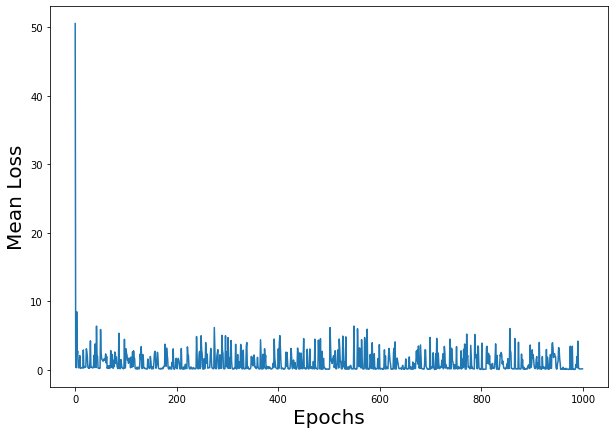

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Loss', fontsize = 20)

## Looks noisy. What's happened?

In [25]:
# Test phase
episodes = 100
rewardsTotal = []

for i in range(episodes):
    done = False
    rewardsEp = []
#     print(f"********** Episode {i} **********")
    while not done:
        # Render environment
        env.render()
        
        state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state = torch.from_numpy(state_).float()
        
        qval = model(state)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print(f'Action: {action}\t Reward: {reward}')
#         print('State: ', state)
        
        # Store reward
        rewardsEp.append(reward)
        
    # Accumulate reward
    rewardTotal = sum(rewardsEp)
    rewardsTotal.append(rewardTotal)
    print('Episode', i, '\t', 'Total reward:', rewardTotal)
    
    
    # Reset environment
    env.reset()
    
env.close()
    
rewardTotalMean = sum(rewardsTotal) / len(rewardsTotal)
print('\nTotal mean reward:', rewardTotalMean)

Episode 0 	 Total reward: 13.0
Episode 1 	 Total reward: 12.0
Episode 2 	 Total reward: 13.0
Episode 3 	 Total reward: 11.0
Episode 4 	 Total reward: 13.0
Episode 5 	 Total reward: 14.0
Episode 6 	 Total reward: 10.0
Episode 7 	 Total reward: 13.0
Episode 8 	 Total reward: 12.0
Episode 9 	 Total reward: 14.0
Episode 10 	 Total reward: 13.0
Episode 11 	 Total reward: 13.0
Episode 12 	 Total reward: 14.0
Episode 13 	 Total reward: 11.0
Episode 14 	 Total reward: 16.0
Episode 15 	 Total reward: 12.0
Episode 16 	 Total reward: 13.0
Episode 17 	 Total reward: 14.0
Episode 18 	 Total reward: 15.0
Episode 19 	 Total reward: 10.0
Episode 20 	 Total reward: 14.0
Episode 21 	 Total reward: 13.0
Episode 22 	 Total reward: 14.0
Episode 23 	 Total reward: 12.0
Episode 24 	 Total reward: 12.0
Episode 25 	 Total reward: 11.0
Episode 26 	 Total reward: 16.0
Episode 27 	 Total reward: 15.0
Episode 28 	 Total reward: 11.0
Episode 29 	 Total reward: 16.0
Episode 30 	 Total reward: 11.0
Episode 31 	 Total

## Seems like it isn't actually learning... Let's try with experience replay to not forget past situations.

In [39]:
# Setup model
l1 = 4
l2 = 150
l3 = 100
l4 = 2
gamma = 0.9
epsMin, epsMax = 0.2, 0.7
epsilon = epsMax
learning_rate = 1e-3

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [55]:
# Reset environment
env.reset()

# Train phase
epochs = 1000
losses = []

# Define experience replay params
bufferSize = epochs // 5
batchSize = bufferSize // 4
replay = deque(maxlen = bufferSize)

for i in range(epochs):
    state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
    state1 = torch.from_numpy(state_).float()
    done = False
    lossesEp = []
    while not done:
        qval = model(state1)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        if (random.random() < epsilon):
#             print('Sample random')
            action = np.random.randint(0, 2)
        else:
#             print('Sample Q')
            action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print('Action: ', action)
#         print('State: ', state)
        
        state2_ = np.asarray(state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state2 = torch.from_numpy(state2_).float()
        
        # Store experience
        exp = (state1, action, reward, state2, done)
        replay.append(exp)
        
        state1 = state2
        
        # Start training if enough experience
        if len(replay) > batchSize:
            batch = random.sample(replay, batchSize)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in batch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in batch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in batch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in batch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in batch])
            
            Q1 = model(state1_batch)
            
            with torch.no_grad():
                Q2 = model(state2_batch)
        
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim = 1)[0])
            X = Q1.gather(dim = 1, index = action_batch.long().unsqueeze(dim = 1)).squeeze()
        
            loss = loss_fn(X, Y.detach())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Store loss
            lossesEp.append(loss.item())
    
    # Accumulate loss
    if len(lossesEp) > 0:
        lossEpMean = sum(lossesEp) / len(lossesEp)
        losses.append(lossEpMean)
        print('Episode', i + 1, '\t', 'Loss:', lossEpMean)
    
    # Reset environment
    env.reset()
    
    if epsilon > epsMin:
        epsilon -= ((epsMax - epsMin) / epochs)

Episode 2 	 Loss: 1.0851751821381705
Episode 3 	 Loss: 1.3476479819842748
Episode 4 	 Loss: 2.0662014917893843
Episode 5 	 Loss: 2.9038157272338867
Episode 6 	 Loss: 3.3570860964911327
Episode 7 	 Loss: 3.412113959972675
Episode 8 	 Loss: 1.7101963467714263
Episode 9 	 Loss: 1.245849646627903
Episode 10 	 Loss: 1.3596164728993567
Episode 11 	 Loss: 1.4471473963487715
Episode 12 	 Loss: 1.3135848682035098
Episode 13 	 Loss: 1.2164112858474254
Episode 14 	 Loss: 1.240959225098292
Episode 15 	 Loss: 1.3505902660113793
Episode 16 	 Loss: 1.1180378292004267
Episode 17 	 Loss: 1.6992917385968296
Episode 18 	 Loss: 1.2982428146260125
Episode 19 	 Loss: 1.1378224243720372
Episode 20 	 Loss: 1.8964370174273368
Episode 21 	 Loss: 2.8522487896861453
Episode 22 	 Loss: 1.1051219191515085
Episode 23 	 Loss: 0.343591524843584
Episode 24 	 Loss: 0.401813156574088
Episode 25 	 Loss: 0.5554909698665143
Episode 26 	 Loss: 1.1319229510568438
Episode 27 	 Loss: 0.740520715713501
Episode 28 	 Loss: 1.40767

Episode 215 	 Loss: 0.4545229172799736
Episode 216 	 Loss: 0.33958634303417057
Episode 217 	 Loss: 0.47453186015288035
Episode 218 	 Loss: 0.38900202661752703
Episode 219 	 Loss: 0.6162800277272861
Episode 220 	 Loss: 0.7870424037629907
Episode 221 	 Loss: 0.7207942073103748
Episode 222 	 Loss: 0.7738342049874758
Episode 223 	 Loss: 1.1585804571708043
Episode 224 	 Loss: 1.101177850495214
Episode 225 	 Loss: 0.7467490973718026
Episode 226 	 Loss: 0.654765076107449
Episode 227 	 Loss: 0.42019899451816584
Episode 228 	 Loss: 0.3277915084858735
Episode 229 	 Loss: 0.3549400025357803
Episode 230 	 Loss: 0.46642080321907997
Episode 231 	 Loss: 0.8637280049068587
Episode 232 	 Loss: 0.6450295805931091
Episode 233 	 Loss: 0.49438694393948507
Episode 234 	 Loss: 0.5227164794629979
Episode 235 	 Loss: 0.4311701529659331
Episode 236 	 Loss: 0.5502031296491623
Episode 237 	 Loss: 0.3427956063391232
Episode 238 	 Loss: 0.3765272593723153
Episode 239 	 Loss: 0.37521935048802146
Episode 240 	 Loss: 

Episode 426 	 Loss: 0.37279480456241537
Episode 427 	 Loss: 0.42133030816912653
Episode 428 	 Loss: 0.5664037594608232
Episode 429 	 Loss: 0.6573660806170665
Episode 430 	 Loss: 0.6460516233814926
Episode 431 	 Loss: 0.38038560732895016
Episode 432 	 Loss: 0.21402198581199627
Episode 433 	 Loss: 0.1062013222917653
Episode 434 	 Loss: 0.12548907801116768
Episode 435 	 Loss: 0.2183859805839184
Episode 436 	 Loss: 0.4069076149087203
Episode 437 	 Loss: 0.35531739926919703
Episode 438 	 Loss: 0.4147008747355012
Episode 439 	 Loss: 0.19992247381896683
Episode 440 	 Loss: 0.348657406093377
Episode 441 	 Loss: 0.23956676691961595
Episode 442 	 Loss: 0.18022023141384125
Episode 443 	 Loss: 0.1468986202740953
Episode 444 	 Loss: 0.30822629135634216
Episode 445 	 Loss: 0.3413293272256851
Episode 446 	 Loss: 0.3446837682841402
Episode 447 	 Loss: 0.2700446724655136
Episode 448 	 Loss: 0.21215487072287603
Episode 449 	 Loss: 0.1162845728065923
Episode 450 	 Loss: 0.07348176484510045
Episode 451 	 

Episode 636 	 Loss: 0.46950633368558353
Episode 637 	 Loss: 0.35593768864870073
Episode 638 	 Loss: 0.19251049309968948
Episode 639 	 Loss: 0.1885836577496013
Episode 640 	 Loss: 0.22038663259445457
Episode 641 	 Loss: 0.2578787540396055
Episode 642 	 Loss: 0.6417783576995134
Episode 643 	 Loss: 0.6222551081910592
Episode 644 	 Loss: 0.8723184466362
Episode 645 	 Loss: 0.32592033747244964
Episode 646 	 Loss: 0.12333131908643537
Episode 647 	 Loss: 0.2339800860028009
Episode 648 	 Loss: 0.5173152414554695
Episode 649 	 Loss: 0.2825361354808722
Episode 650 	 Loss: 0.05617554888885934
Episode 651 	 Loss: 0.055835825158283114
Episode 652 	 Loss: 0.6333988614380359
Episode 653 	 Loss: 0.5678891097195446
Episode 654 	 Loss: 0.7230990772897546
Episode 655 	 Loss: 0.896949139320188
Episode 656 	 Loss: 0.9182072579860687
Episode 657 	 Loss: 1.3172170438549735
Episode 658 	 Loss: 1.4372016657143831
Episode 659 	 Loss: 0.989230105387313
Episode 660 	 Loss: 0.4193950077518821
Episode 661 	 Loss: 0

Episode 846 	 Loss: 0.3711305720795845
Episode 847 	 Loss: 0.40282966904342177
Episode 848 	 Loss: 0.6763439979404211
Episode 849 	 Loss: 0.5300071829635846
Episode 850 	 Loss: 0.42080364948404686
Episode 851 	 Loss: 0.5101008211510091
Episode 852 	 Loss: 0.2798133074012521
Episode 853 	 Loss: 0.27035510043303174
Episode 854 	 Loss: 0.536478690679901
Episode 855 	 Loss: 0.32708071100491065
Episode 856 	 Loss: 0.07073947541754354
Episode 857 	 Loss: 0.06047413426197388
Episode 858 	 Loss: 0.40478354890512513
Episode 859 	 Loss: 0.6576897447498945
Episode 860 	 Loss: 0.7342102954333479
Episode 861 	 Loss: 0.7462465076574257
Episode 862 	 Loss: 0.6584399135656727
Episode 863 	 Loss: 0.4899221807718277
Episode 864 	 Loss: 0.2612774452337852
Episode 865 	 Loss: 0.5224935985528506
Episode 866 	 Loss: 0.7635285373438488
Episode 867 	 Loss: 0.4056188038563075
Episode 868 	 Loss: 0.056732646650634704
Episode 869 	 Loss: 0.11418144990290914
Episode 870 	 Loss: 0.11672628310819468
Episode 871 	 L

Text(0, 0.5, 'Mean Loss')

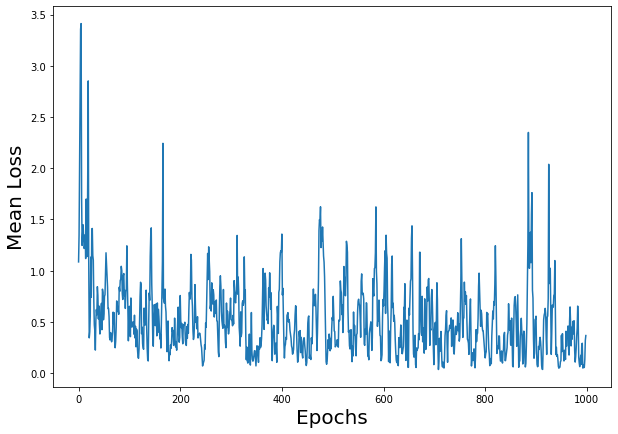

In [56]:
plt.figure(figsize = (10, 7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Loss', fontsize = 20)

## Although pretty uneven, this loss is definitely better in terms of absolute values. Does it mean the model has learnt something?

In [57]:
# Test phase
episodes = 100
rewardsTotal = []

for i in range(episodes):
    done = False
    rewardsEp = []
#     print(f"********** Episode {i} **********")
    while not done:
        # Render environment
        env.render()
        
        state_ = np.asarray(env.state, dtype = 'float') + np.random.rand(1, l1) / 10.0
        state = torch.from_numpy(state_).float()
        
        qval = model(state)
        qval_ = qval.data.numpy()
#         print('Qs: ', qval_)
        
        action = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action)
#         print(f'Action: {action}\t Reward: {reward}')
#         print('State: ', state)
        
        # Store reward
        rewardsEp.append(reward)
        
    # Accumulate reward
    rewardTotal = sum(rewardsEp)
    rewardsTotal.append(rewardTotal)
    print('Episode', i, '\t', 'Total reward:', rewardTotal)
    
    
    # Reset environment
    env.reset()
    
env.close()
    
rewardTotalMean = sum(rewardsTotal) / len(rewardsTotal)
print('\nTotal mean reward:', rewardTotalMean)

Episode 0 	 Total reward: 200.0
Episode 1 	 Total reward: 200.0
Episode 2 	 Total reward: 200.0
Episode 3 	 Total reward: 200.0
Episode 4 	 Total reward: 200.0
Episode 5 	 Total reward: 200.0
Episode 6 	 Total reward: 200.0
Episode 7 	 Total reward: 176.0
Episode 8 	 Total reward: 200.0
Episode 9 	 Total reward: 200.0
Episode 10 	 Total reward: 200.0
Episode 11 	 Total reward: 200.0
Episode 12 	 Total reward: 200.0
Episode 13 	 Total reward: 200.0
Episode 14 	 Total reward: 200.0
Episode 15 	 Total reward: 200.0
Episode 16 	 Total reward: 200.0
Episode 17 	 Total reward: 200.0
Episode 18 	 Total reward: 200.0
Episode 19 	 Total reward: 200.0
Episode 20 	 Total reward: 200.0
Episode 21 	 Total reward: 200.0
Episode 22 	 Total reward: 200.0
Episode 23 	 Total reward: 200.0
Episode 24 	 Total reward: 200.0
Episode 25 	 Total reward: 195.0
Episode 26 	 Total reward: 200.0
Episode 27 	 Total reward: 200.0
Episode 28 	 Total reward: 200.0
Episode 29 	 Total reward: 200.0
Episode 30 	 Total r

## Yay! It has actually learned how to play the game!